## Введение

### Описание задачи

Из Инвестиционной компании Иволга стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

### Краткое описание проекта

Проект посвящен выбору модели и обучению модели для предсказания ухода клиента из брокерского сервиса. Важным аспектом проекта является корректная подготовка признаков и качественное тестирование лучшей модели.

### Описание данных

**ДАННЫЕ:** Исторические данные о поведении клиентов и расторжении договоров с брокером. 


**Признаки**
- *RowNumber —* индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname —* фамилия
- *CreditScore —* кредитный рейтинг
- *Geography —* страна проживания
- *Gender —* пол
- *Age —* возраст
- *Tenure —* сколько лет человек является клиентом брокера
- *Balance —* баланс на счёте
- *NumOfProducts —* количество инвестиционных продуктов, используемых клиентом
- *HasCrCard —* наличие кредитной карты
- *IsActiveMember —* активность клиента
- *EstimatedSalary —* предполагаемая зарплата

**Целевой признак**
- *Exited* — факт ухода клиента

### План исследования

1. Импорт и первичный анализ датасета
2. Первичное изменение датасета для удобства работы
3. Разделение датасета на признаки и целевые признаки
4. Исследование баланса классов целевого признака
5. Разбиение выборок для обучения моделей
6. Подготовка категориальных признаков для обучения моделей
7. Подготовка численных признаков для обучения моделей
9. Апсемплинг / Даунсемплинг обучающих выборок
9. Исследование баланса классов целевого признака Апсемплинг / Даунсемплинг
10. Выбор моделей
11. Тест моделей с перебором гиперпараметров на несбалансированной и сбалансированных выборках
12. Выбор лучшей модели



##  Исследование

### Imports

In [1]:
!pip install imblearn

In [2]:
from imblearn.over_sampling import SMOTENC # апсемплинг для микса кат и нум фичей
from imblearn.under_sampling import RandomUnderSampler # даунсемплинг для микса кат и нум фичей

In [3]:
# импорты из стандартной библиотеки
import re
from re import sub
import warnings
warnings.filterwarnings('ignore')

# импорты сторонних библиотек
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None # При записи изменённых признаков в исходный датафрейм код может вызывать предупреждение SettingWithCopy.
import seaborn as sns
import time
import imblearn

# импорты модулей текущего проекта
from sklearn.preprocessing import OneHotEncoder # Кодирование для классификационных алгоритмов
from sklearn.preprocessing import StandardScaler # Стандартизация
from sklearn.utils import shuffle # Миксер
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score # Точность модели
from sklearn.metrics import confusion_matrix # Матрица ошибок
from sklearn.metrics import recall_score # Полнота
from sklearn.metrics import precision_score # Точность предсказаний
from sklearn.metrics import f1_score # Среднегармоническое полноты и точности
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTENC # апсемплинг для микса кат и нум фичей
from imblearn.under_sampling import RandomUnderSampler # даунсемплинг для микса кат и нум фичей

# константы
RND_STATE = 12345

### Импорт и первичный анализ датасета

In [4]:
# создадим функцию для быстрого анализа датасетов
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [5]:
# dataset import
try:
    data = pd.read_csv('/datasets/Churn.csv')
    print('local data loaded')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
    print('local data unavailable. data loaded from https://code.s3.yandex.net/datasets/Churn.csv')

local data unavailable. data loaded from https://code.s3.yandex.net/datasets/Churn.csv


In [6]:
# data review
get_data_info(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5469,5470,15678571,Barber,723,France,Male,21,NaN,0.0,2,0,0,24847.02,0
4195,4196,15747168,Sanders,626,Germany,Female,47,2.0,103108.8,1,0,1,166475.44,1
752,753,15677305,Hsieh,490,France,Female,35,7.0,107749.03,1,1,1,3937.37,0
7307,7308,15782159,Ndubuagha,850,France,Male,28,8.0,67639.56,2,1,1,194245.29,0
7214,7215,15652658,Finch,721,France,Male,36,1.0,155176.83,2,1,1,49653.37,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.0,10000.0,10000,10000.0,10000,10000,10000.0,9091.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.5,15690940.5694,NaN,650.5288,NaN,NaN,38.9218,4.997690023099769,76485.889288,1.5302,0.7055,0.5151,100090.239881,0.2037
std,2886.8956799071675,71936.1861227489,NaN,96.65329873613035,NaN,NaN,10.487806451704609,2.894723234821247,62397.405202385955,0.5816543579989906,0.4558404644751333,0.49979692845891893,57510.49281769816,0.4027685839948609
min,1.0,15565701.0,NaN,350.0,NaN,NaN,18.0,0.0,0.0,1.0,0.0,0.0,11.58,0.0
25%,2500.75,15628528.25,NaN,584.0,NaN,NaN,32.0,2.0,0.0,1.0,0.0,0.0,51002.11,0.0
50%,5000.5,15690738.0,NaN,652.0,NaN,NaN,37.0,5.0,97198.54000000001,1.0,1.0,1.0,100193.915,0.0
75%,7500.25,15753233.75,NaN,718.0,NaN,NaN,44.0,7.0,127644.24,2.0,1.0,1.0,149388.2475,0.0


### Первичное изменение датасета для удобства работы

In [7]:
# to snake_case
data.columns = [re.sub(r'(?<=!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [8]:
# check columns renaming
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [9]:
# смотрим пропуски
data.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [10]:
# смотрим дубликаты
print('Соотношение дубликатов и уникальных значений в признаках:')
duplicates_list = []
unique_list = []
for column_name in data.columns:
    duplicates_list.append(data[column_name].duplicated().sum())
    unique_list.append(len(data[column_name].unique()))
pivot = pd.DataFrame()
pivot['Признак'] = data.columns
pivot['Количество дубликатов'] = duplicates_list
pivot['Количество уникальных значений'] = unique_list

pivot.style.bar()

Соотношение дубликатов и уникальных значений в признаках:


,Признак,Количество дубликатов,Количество уникальных значений
0,rownumber,0,10000
1,customerid,0,10000
2,surname,7068,2932
3,creditscore,9540,460
4,geography,9997,3
5,gender,9998,2
6,age,9930,70
7,tenure,9988,12
8,balance,3618,6382
9,numofproducts,9996,4


#### column 'tenure'
В колонке есть пропуски. Nan заполним значением 0

In [11]:
data.tenure = data.tenure.fillna(0)

In [12]:
# check tenure nan filling to 0
data.tenure.value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

#### column 'row_number'
Совпадает с индексом. Для обучения модели не пригодится. Удаляем

In [13]:
data = data.drop(['rownumber'], axis=1)

#### column 'surname'
Много дубликатов. Похоже на синтетические данные. Для обучения модели не пригодится. Удаляем

In [14]:
# смотрим на распределение фамилий
data.surname.value_counts().head(30)

Smith        32
Martin       29
Scott        29
Walker       28
Brown        26
Genovese     25
Yeh          25
Shih         25
Maclean      24
Wright       24
Wilson       23
Ma           23
White        23
Fanucci      23
Lu           22
Wang         22
Johnson      22
Moore        22
Chu          22
Mai          21
McGregor     21
Thompson     21
Sun          21
Kao          20
Fang         20
Lo           20
Palerma      20
Kennedy      20
Kerr         20
Trevisani    20
Name: surname, dtype: int64

In [15]:
data = data.drop(['surname'], axis=1)

#### column 'customer_id'
Все значения уникальны, рандомны. Для обучения модели не нужны. Удаляем

In [16]:
data = data.drop(['customerid'], axis=1)

In [17]:
# check final columns count
data.columns.to_list()

['creditscore',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'numofproducts',
 'hascrcard',
 'isactivemember',
 'estimatedsalary',
 'exited']

#### Проверка корреляции признаков

##### Мультиколлинеарность

Исследование мультиколлинеарности необходимо для выявления сильно связанных признаков, которые могут помешать в обучении модели своей связанностью.

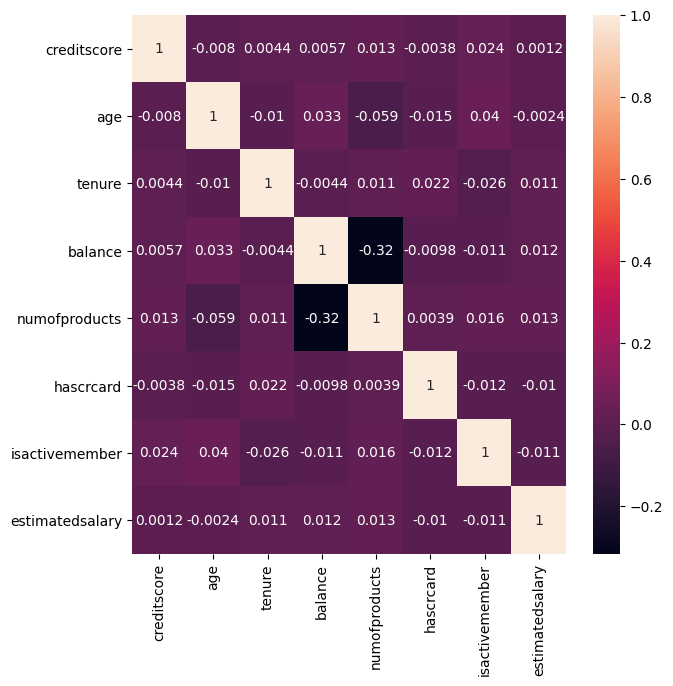

In [18]:
spearman = data.drop(['exited'], axis=1).corr(method='spearman')
sns.heatmap(data=spearman,annot=True)
plt.gcf().set_size_inches(7,7);

Вывод: Сильносвязанных признаков не выявлено. Значит дополнительно удалять признаки из датасета для корректного обучения моделей не нужно. Отмечается отрицательная обратная связь признаков `balance` и `numberofproducts`, но она обучению моделей не помешает.

##### Исследование корреляции признаков по парам

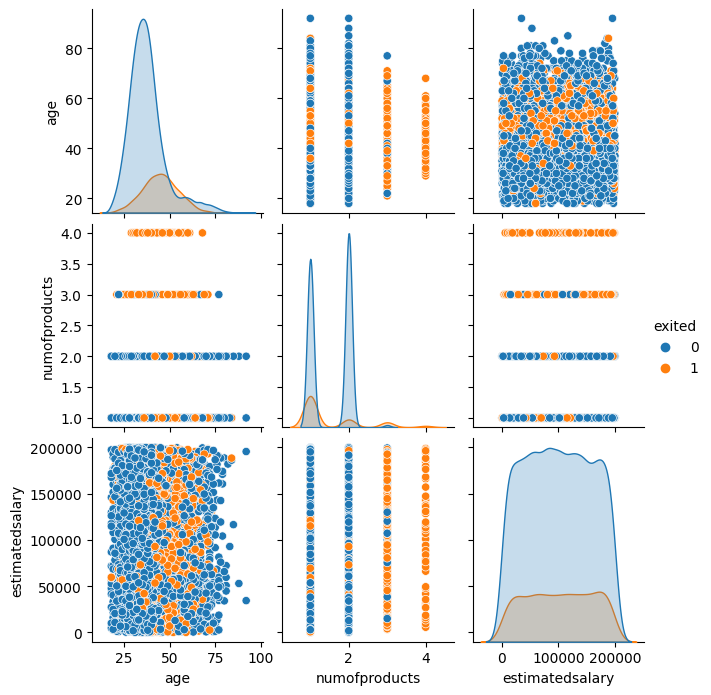

In [19]:
pairplot = data.drop(['tenure', 'balance', 'creditscore', 'hascrcard', 'isactivemember'], axis=1)
sns.pairplot(pairplot, hue = 'exited')
plt.gcf().set_size_inches(7,7);

Выше построены графики взаимосвязи признаков по парам, отностительно признака `exited`. 
Зависимости видны по признакам `age`, `estimatedsalary` и `balance`.
Первичная оценка факта ухода клиентов по этому графику приводит к мысли, что уходят клиенты ~ 50 лет с малым количеством продуктов и невысокой заработной платной.

### Разделение датасета на признаки и целевые признаки

In [20]:
# разбиваем датасет на фичи и целевой признак
features = data.drop(['exited'], axis=1)
target = data.exited
features.shape, target.shape

((10000, 10), (10000,))

### Разделение датасета на выборки

разбивать датасет будем сразу на три выборки:
- обучающую (train): 60%
- валидационную (valid): 20%
- тестовую (test): 20%

In [21]:
# отделение 20% данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target,
    train_size = .60,
    random_state = RND_STATE,
    stratify=target
)
# отделение 20% данных для валидационной выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, 
    target_valid, 
    train_size = 0.5, 
    random_state = RND_STATE, 
    stratify=target_valid
)

In [22]:
# check
features_train_size = len(features_train)/len(features)
target_train_size = len(target_train)/len(target)
features_valid_size = len(features_valid)/len(features)
target_valid_size = len(target_valid)/len(target)
features_test_size = len(features_test)/len(features)
target_test_size = len(target_test)/len(target)

splits = pd.DataFrame(
    {'split_name' : [
        'features_train', 
        'target_train', 
        'features_valid', 
        'target_valid', 
        'features_test', 
        'target_test'],
    'rows' : [
        len(features_train), 
        len(target_train), 
        len(features_valid), 
        len(target_valid), 
        len(features_test), 
        len(target_test)],
    'size' : [
        features_train_size, 
        target_train_size, 
        features_valid_size, 
        target_valid_size,
        features_test_size, 
        target_test_size]})
splits

,split_name,rows,size
0,features_train,6000,0.6
1,target_train,6000,0.6
2,features_valid,2000,0.2
3,target_valid,2000,0.2
4,features_test,2000,0.2
5,target_test,2000,0.2


### Подготовка признаков

#### список категориальных признаков

In [23]:
cat_features = data.select_dtypes(include='object').columns.to_list()
cat_features

['geography', 'gender']

#### список численных признаков

In [24]:
numeric_features = data.select_dtypes(exclude='object').columns.to_list()
numeric_features.remove('exited') # целевой признак
numeric_features.remove('hascrcard') # категориальный и бинарный
numeric_features.remove('isactivemember') # категориальный и бинарный
numeric_features

['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

#### Кодирование и масштабирование

In [25]:
## Кодирование категориальных признаков техникой One-Hot Encoding
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[cat_features])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[cat_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(cat_features, axis=1)

In [26]:
## Масштабирование численных признаков техникой StandardScaler
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[numeric_features] = scaler.fit_transform(features_train[numeric_features])

In [27]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[cat_features])

features_valid = features_valid.drop(cat_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_valid[numeric_features] = scaler.transform(features_valid[numeric_features])

In [28]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[cat_features])

features_test = features_test.drop(cat_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

### Исследование баланса классов

0   0.7963
1   0.2037
Name: exited, dtype: float64


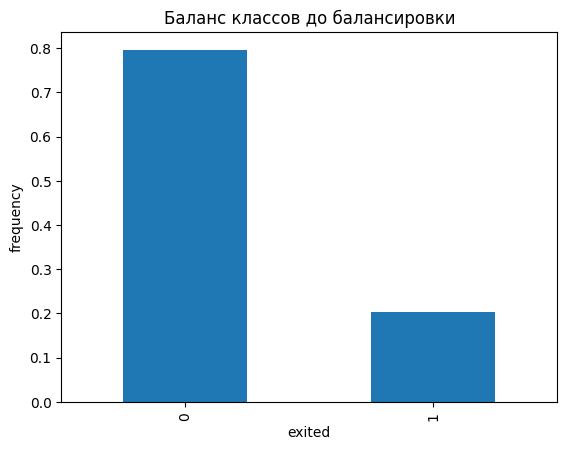

In [29]:
# проверяем развесовку классов целевого признака до балансировки
target_class_frequency = target.value_counts(normalize=True)
print(target_class_frequency);
target_class_frequency.plot(kind='bar', xlabel='exited', ylabel='frequency', title='Баланс классов до балансировки');

## Балансировка обучающих выборок

### Увеличение выборки

In [30]:
# Техника избыточной выборки синтетических меньшинств (SMOTE) только на обучающей выборке
sm_cat = SMOTENC(random_state=RND_STATE, categorical_features=[1, 2])
features_upsampled, target_upsampled = sm_cat.fit_resample(features_train, target_train)
features_upsampled.shape, target_upsampled.shape

((9556, 11), (9556,))

0    4778
1    4778
Name: exited, dtype: int64


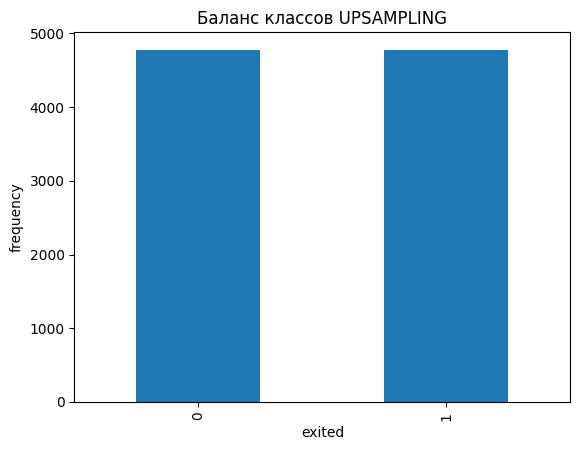

In [31]:
# проверяем развесовку классов целевого признака UPSAMPLING
target_class_frequency_upsampled = target_upsampled.value_counts(normalize=False)
print(target_class_frequency_upsampled);
target_class_frequency_upsampled.plot(kind='bar', xlabel='exited', ylabel='frequency', title='Баланс классов UPSAMPLING');

### Уменьшение выборки

In [32]:
rus = RandomUnderSampler(random_state=RND_STATE)
features_downsampled, target_downsampled = rus.fit_resample(features_train, target_train)
features_downsampled.shape, target_downsampled.shape

((2444, 11), (2444,))

0    1222
1    1222
Name: exited, dtype: int64


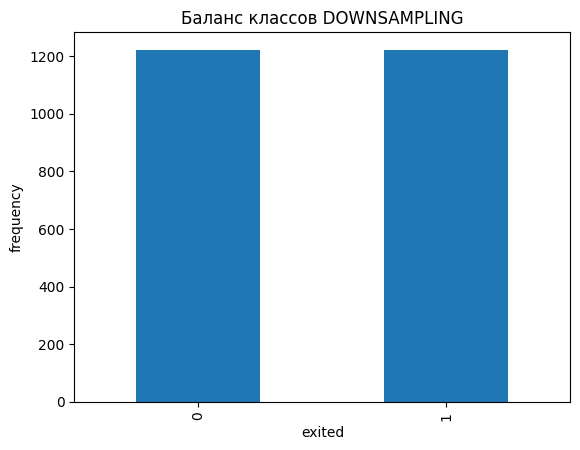

In [33]:
# проверяем развесовку классов целевого признака DOWNSAMPLING
target_class_frequency_downsampled = target_downsampled.value_counts(normalize=False)
print(target_class_frequency_downsampled);
target_class_frequency_downsampled.plot(kind='bar', xlabel='exited', ylabel='frequency', title='Баланс классов DOWNSAMPLING');

### Выводы:
Изучена основная выборка и баланс класса целевого признака. Выборка не сбалансированная, что означает возможные сложности с качественным обучением моделей. Принято решение о балансировке основной выборки двумя техниками. Для увеличения выборки применена техника SMOTENC, работающая в том числе и с категориальными признаками. Для уменьшения выборки применена техника RandomUnderSampler. 

Важно отметить, что балансировка выборок проведена после кодирования категориальных признаков и масштабирования численных признаков. Это сделано с двумя целями. Во-первых сокращение необходимого объема кода и соответственно упрощение как кода, так и названий переменных. Во-вторых это позволяет более точно настроить и провести масштабирование созданным скелером.

## Выбор и обучение моделей

Наша задача является задачей классификации, поскольку целевой признак `'exited'` не является непрерывной величиной. Для обучения будем использовать модели Классификации

### unbalanced testing

#### RandomForestClassifier unbalanced

Выбор лучших гиперпараметров в вложенных циклах

In [34]:
%%time
# выбор гиперпараметров

f1_score_rfc_best = 0
for depth_rfc in range(1, 15, 1):
    for est_rfc in range(50, 250, 50):
        model_rfc = RandomForestClassifier(random_state=RND_STATE, 
                                                      max_depth=depth_rfc, 
                                                      n_estimators=est_rfc)
        model_rfc.fit(features_train, target_train)

        predictions_rfc = pd.Series(model_rfc.predict(features_valid))
        result_rfc = accuracy_score(target_valid, predictions_rfc)
        precision_score_rfc = precision_score(target_valid, predictions_rfc)
        recall_score_rfc = recall_score(target_valid, predictions_rfc)
        f1_score_rfc = f1_score(target_valid, predictions_rfc)
    
        probabilities_rfc = model_rfc.predict_proba(features_valid)
        probabilities_one_rfc = probabilities_rfc[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_rfc) 

        if f1_score_rfc > f1_score_rfc_best:
            f1_score_rfc_best = f1_score_rfc
            best_depth_rfc = depth_rfc
            best_est_rfc = est_rfc
print('RandomForestClassifier unbalanced')
print('Точность попадания по классам:', result_rfc)
print('Precision', precision_score_rfc)
print('Recall', recall_score_rfc)
print('F1', f1_score_rfc)
print('ROC-AUC:', auc_roc_rfc)
print('Лучший гиперпараметр max_depth:', best_depth_rfc)
print('Лучший гиперпараметр n_estimators:', best_est_rfc)

RandomForestClassifier unbalanced
Точность попадания по классам: 0.8535
Precision 0.7394957983193278
Recall 0.43243243243243246
F1 0.5457364341085271
ROC-AUC: 0.8515973600719364
Лучший гиперпараметр max_depth: 13
Лучший гиперпараметр n_estimators: 150
CPU times: total: 1min 19s
Wall time: 1min 19s


#### LogisicRegression unbalanced

In [35]:
%%time

f1_score_lr_best = 0

model_lr = LogisticRegression(random_state=RND_STATE, solver='liblinear')
model_lr.fit(features_train, target_train)

predictions_lr = pd.Series(model_lr.predict(features_valid))
result_lr = accuracy_score(target_valid, predictions_lr)
precision_score_lr = precision_score(target_valid, predictions_lr)
recall_score_lr = recall_score(target_valid, predictions_lr)
f1_score_lr = f1_score(target_valid, predictions_lr)
    
probabilities_lr = model_lr.predict_proba(features_valid)
probabilities_one_lr = probabilities_lr[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_lr) 

if f1_score_lr > f1_score_lr_best:
    f1_score_lr_best = f1_score_lr

print('LogisicRegression unbalanced')
print('Точность попадания по классам:', result_lr)
print('Precision', precision_score_lr)
print('Recall', recall_score_lr)
print('F1', f1_score_lr)
print('ROC-AUC:', auc_roc_lr)

LogisicRegression unbalanced
Точность попадания по классам: 0.812
Precision 0.624
Recall 0.19164619164619165
F1 0.2932330827067669
ROC-AUC: 0.750337394405191
CPU times: total: 31.2 ms
Wall time: 37 ms


### class_weight='balanced' models

#### RandomForestClassifier class_weight_balanced

In [36]:
%%time
# выбор гиперпараметров

f1_score_rfc_cw_best = 0
for depth_rfc_cw in range(1, 15, 1):
    for est_rfc_cw in range(50, 250, 50):
        model_rfc_cw = RandomForestClassifier(class_weight='balanced',
                                                      random_state=RND_STATE, 
                                                      max_depth=depth_rfc_cw, 
                                                      n_estimators=est_rfc_cw)
        model_rfc_cw.fit(features_train, target_train)

        predictions_rfc_cw = pd.Series(model_rfc_cw.predict(features_valid))
        result_rfc_cw = accuracy_score(target_valid, predictions_rfc_cw)
        precision_score_rfc_cw = precision_score(target_valid, predictions_rfc_cw)
        recall_score_rfc_cw = recall_score(target_valid, predictions_rfc_cw)
        f1_score_rfc_cw = f1_score(target_valid, predictions_rfc_cw)
    
        probabilities_rfc_cw = model_rfc_cw.predict_proba(features_valid)
        probabilities_one_rfc_cw = probabilities_rfc_cw[:, 1]
        auc_roc_rfc_cw = roc_auc_score(target_valid, probabilities_one_rfc_cw) 

        if f1_score_rfc_cw > f1_score_rfc_cw_best:
            f1_score_rfc_cw_best = f1_score_rfc_cw
            best_depth_rfc_cw = depth_rfc_cw
            best_est_rfc_cw = est_rfc_cw
print('RandomForestClassifier class_weight')
print('Точность попадания по классам:', result_rfc_cw)
print('Precision', precision_score_rfc_cw)
print('Recall', recall_score_rfc_cw)
print('F1', f1_score_rfc_cw)
print('ROC-AUC:', auc_roc_rfc_cw)
print('Лучший гиперпараметр max_depth:', best_depth_rfc_cw)
print('Лучший гиперпараметр n_estimators:', best_est_rfc_cw)

RandomForestClassifier class_weight
Точность попадания по классам: 0.845
Precision 0.6725978647686833
Recall 0.4643734643734644
F1 0.5494186046511628
ROC-AUC: 0.8486467977993402
Лучший гиперпараметр max_depth: 8
Лучший гиперпараметр n_estimators: 200
CPU times: total: 1min 20s
Wall time: 1min 20s


#### LogisicRegression_cw_balanced

In [37]:
%%time

f1_score_lr_cw_best = 0

model_lr_cw = LogisticRegression(class_weight='balanced', random_state=RND_STATE, solver='liblinear')
model_lr_cw.fit(features_train, target_train)

predictions_lr_cw = pd.Series(model_lr_cw.predict(features_valid))
result_lr_cw = accuracy_score(target_valid, predictions_lr_cw)
precision_score_lr_cw = precision_score(target_valid, predictions_lr_cw)
recall_score_lr_cw = recall_score(target_valid, predictions_lr_cw)
f1_score_lr_cw = f1_score(target_valid, predictions_lr_cw)
    
probabilities_lr_cw = model_lr_cw.predict_proba(features_valid)
probabilities_one_lr_cw = probabilities_lr_cw[:, 1]
auc_roc_lr_cw = roc_auc_score(target_valid, probabilities_one_lr_cw) 

if f1_score_lr_cw > f1_score_lr_cw_best:
    f1_score_lr_cw_best = f1_score_lr_cw

print('LogisicRegression class_weight')
print('Точность попадания по классам:', result_lr_cw)
print('Precision', precision_score_lr_cw)
print('Recall', recall_score_lr_cw)
print('F1', f1_score_lr_cw)
print('ROC-AUC:', auc_roc_lr_cw)

LogisicRegression class_weight
Точность попадания по классам: 0.699
Precision 0.36877523553162855
Recall 0.6732186732186732
F1 0.4765217391304348
ROC-AUC: 0.7541146693689067
CPU times: total: 31.2 ms
Wall time: 40.8 ms


### Upsampled models

#### RandomForestClassifier upsampled

In [38]:
%%time
# выбор гиперпараметров

f1_score_rfc_up_best = 0
for depth_rfc_up in range(1, 15, 1):
    for est_rfc_up in range(50, 250, 50):
        model_rfc_up = RandomForestClassifier(random_state=RND_STATE, 
                                                      max_depth=depth_rfc_up, 
                                                      n_estimators=est_rfc_up)
        model_rfc_up.fit(features_upsampled, target_upsampled)

        predictions_rfc_up = pd.Series(model_rfc_up.predict(features_valid))
        result_rfc_up = accuracy_score(target_valid, predictions_rfc_up)
        precision_score_rfc_up = precision_score(target_valid, predictions_rfc_up)
        recall_score_rfc_up = recall_score(target_valid, predictions_rfc_up)
        f1_score_rfc_up = f1_score(target_valid, predictions_rfc_up)
    
        probabilities_rfc_up = model_rfc_up.predict_proba(features_valid)
        probabilities_one_rfc_up = probabilities_rfc_up[:, 1]
        auc_roc_rfc_up = roc_auc_score(target_valid, probabilities_one_rfc_up) 

        if f1_score_rfc_up > f1_score_rfc_up_best:
            f1_score_rfc_up_best = f1_score_rfc_up
            best_depth_rfc_up = depth_rfc_up
            best_est_rfc_up = est_rfc_up
print('RandomForestClassifier upsampled')
print('Точность попадания по классам:', result_rfc_up)
print('Precision', precision_score_rfc_up)
print('Recall', recall_score_rfc_up)
print('F1', f1_score_rfc_up)
print('ROC-AUC:', auc_roc_rfc_up)
print('Лучший гиперпараметр max_depth:', best_depth_rfc_up)
print('Лучший гиперпараметр n_estimators:', best_est_rfc_up)

RandomForestClassifier upsampled
Точность попадания по классам: 0.8175
Precision 0.5460526315789473
Recall 0.6117936117936118
F1 0.5770567786790266
ROC-AUC: 0.8408053662290951
Лучший гиперпараметр max_depth: 9
Лучший гиперпараметр n_estimators: 100
CPU times: total: 2min 7s
Wall time: 2min 8s


#### LogisticRegression upsampled

In [39]:
%%time

f1_score_lr_up_best = 0

model_lr_up = LogisticRegression(random_state=RND_STATE, solver='liblinear')
model_lr_up.fit(features_upsampled, target_upsampled)

predictions_lr_up = pd.Series(model_lr_up.predict(features_valid))
result_lr_up = accuracy_score(target_valid, predictions_lr_up)
precision_score_lr_up = precision_score(target_valid, predictions_lr_up)
recall_score_lr_up = recall_score(target_valid, predictions_lr_up)
f1_score_lr_up = f1_score(target_valid, predictions_lr_up)
    
probabilities_lr_up = model_lr_up.predict_proba(features_valid)
probabilities_one_lr_up = probabilities_lr_up[:, 1]
auc_roc_lr_up = roc_auc_score(target_valid, probabilities_one_lr_up) 

if f1_score_lr_up > f1_score_lr_up_best:
    f1_score_lr_up_best = f1_score_lr_up

print('LogisicRegression upsampled')
print('Точность попадания по классам:', result_lr_up)
print('Precision', precision_score_lr_up)
print('Recall', recall_score_lr_up)
print('F1', f1_score_lr_up)
print('ROC-AUC:', auc_roc_lr_up)

LogisicRegression upsampled
Точность попадания по классам: 0.7
Precision 0.3683492496589359
Recall 0.6633906633906634
F1 0.47368421052631576
ROC-AUC: 0.7504854623498691
CPU times: total: 31.2 ms
Wall time: 40.1 ms


### Downsampled models

#### RandomForestClassifier downsampled

In [40]:
%%time
# выбор гиперпараметров

f1_score_rfc_down_best = 0
for depth_rfc_down in range(1, 15, 1):
    for est_rfc_down in range(50, 250, 50):
        model_rfc_down = RandomForestClassifier(random_state=RND_STATE, 
                                                      max_depth=depth_rfc_down, 
                                                      n_estimators=est_rfc_down)
        model_rfc_down.fit(features_downsampled, target_downsampled)

        predictions_rfc_down = pd.Series(model_rfc_down.predict(features_valid))
        result_rfc_down = accuracy_score(target_valid, predictions_rfc_down)
        precision_score_rfc_down = precision_score(target_valid, predictions_rfc_down)
        recall_score_rfc_down = recall_score(target_valid, predictions_rfc_down)
        f1_score_rfc_down = f1_score(target_valid, predictions_rfc_down)
    
        probabilities_rfc_down = model_rfc_down.predict_proba(features_valid)
        probabilities_one_rfc_down = probabilities_rfc_down[:, 1]
        auc_roc_rfc_down = roc_auc_score(target_valid, probabilities_one_rfc_down) 

        if f1_score_rfc_down > f1_score_rfc_down_best:
            f1_score_rfc_down_best = f1_score_rfc_down
            best_depth_rfc_down = depth_rfc_down
            best_est_rfc_down = est_rfc_down
print('RandomForestClassifier downsampled')
print('Точность попадания по классам:', result_rfc_down)
print('Precision', precision_score_rfc_down)
print('Recall', recall_score_rfc_down)
print('F1', f1_score_rfc_down)
print('ROC-AUC:', auc_roc_rfc_down)
print('Лучший гиперпараметр max_depth:', best_depth_rfc_down)
print('Лучший гиперпараметр n_estimators:', best_est_rfc_down)

RandomForestClassifier downsampled
Точность попадания по классам: 0.7695
Precision 0.4590909090909091
Recall 0.7444717444717445
F1 0.5679475164011246
ROC-AUC: 0.8446566751651499
Лучший гиперпараметр max_depth: 7
Лучший гиперпараметр n_estimators: 50
CPU times: total: 45.5 s
Wall time: 46 s


#### LogisticRegression downsampled

In [41]:
%%time

f1_score_lr_down_best = 0

model_lr_down = LogisticRegression(random_state=RND_STATE, solver='liblinear')
model_lr_down.fit(features_downsampled, target_downsampled)

predictions_lr_down = pd.Series(model_lr_down.predict(features_valid))
result_lr_down = accuracy_score(target_valid, predictions_lr_down)
precision_score_lr_down = precision_score(target_valid, predictions_lr_down)
recall_score_lr_down = recall_score(target_valid, predictions_lr_down)
f1_score_lr_down = f1_score(target_valid, predictions_lr_down)
    
probabilities_lr_down = model_lr_down.predict_proba(features_valid)
probabilities_one_lr_down = probabilities_lr_down[:, 1]
auc_roc_lr_down = roc_auc_score(target_valid, probabilities_one_lr_down) 

if f1_score_lr_down > f1_score_lr_down_best:
    f1_score_lr_down_best = f1_score_lr_down

print('LogisicRegression downsampled')
print('Точность попадания по классам:', result_lr_down)
print('Precision', precision_score_lr_down)
print('Recall', recall_score_lr_down)
print('F1', f1_score_lr_down)
print('ROC-AUC:', auc_roc_lr_down)

LogisicRegression downsampled
Точность попадания по классам: 0.6995
Precision 0.3699731903485255
Recall 0.6781326781326781
F1 0.4787510841283608
ROC-AUC: 0.7524905491007186
CPU times: total: 31.2 ms
Wall time: 41.4 ms


### Best Model

Лучшей моделью оказалась нижеозначенная модель, обученная на увеличенной обучающей выборке.
Тестирование будем проводить на несбалансированной тестовой выборке с нижеследующими параметрами.

RandomForestClassifier upsampled

- RandomForestClassifier upsampled
- Точность попадания по классам: 0.8175
- Precision 0.5460526315789473
- Recall 0.6117936117936118
- F1 0.5770567786790266
- ROC-AUC: 0.8408053662290951
- Лучший гиперпараметр max_depth: 9
- Лучший гиперпараметр n_estimators: 100

In [42]:
%%time
# выбор гиперпараметров

f1_score_final_best = 0

model_final = RandomForestClassifier(random_state=RND_STATE, max_depth=9, n_estimators=100)
model_final.fit(features_upsampled, target_upsampled)
predictions_final = pd.Series(model_final.predict(features_test))
result_final = accuracy_score(target_test, predictions_final)
precision_score_final = precision_score(target_test, predictions_final)
recall_score_final = recall_score(target_test, predictions_final)
f1_score_final = f1_score(target_test, predictions_final)

probabilities_final = model_final.predict_proba(features_test)
probabilities_one_final = probabilities_final[:, 1]
auc_roc_final = roc_auc_score(target_test, probabilities_one_final) 

if f1_score_final > f1_score_final_best:
    f1_score_final_best = f1_score_final

print('RandomForestClassifier upsampled')
print('Точность попадания по классам:', result_final)
print('Precision', precision_score_final)
print('Recall', recall_score_final)
print('F1', f1_score_final)
print('ROC-AUC:', auc_roc_final)

RandomForestClassifier upsampled
Точность попадания по классам: 0.8355
Precision 0.5766990291262136
Recall 0.7279411764705882
F1 0.6435536294691224
ROC-AUC: 0.8707554315696128
CPU times: total: 2.19 s
Wall time: 2.2 s


### Best Model Матрица ошибок

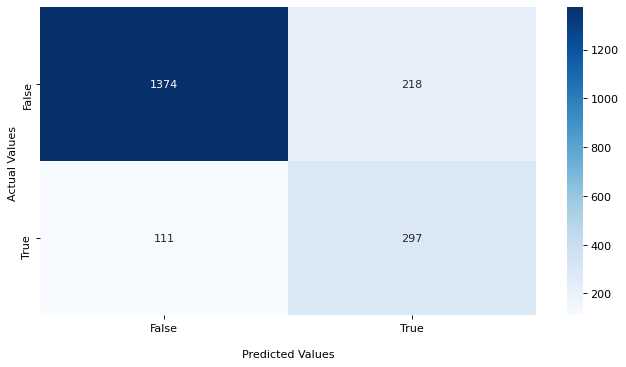

In [43]:
cf_matrix_rfc = confusion_matrix(target_test, predictions_final)
plt.figure(figsize=(10, 5), dpi=80)

ax = sns.heatmap(cf_matrix_rfc, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Best Model ROC-curve

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»). Это новая метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.

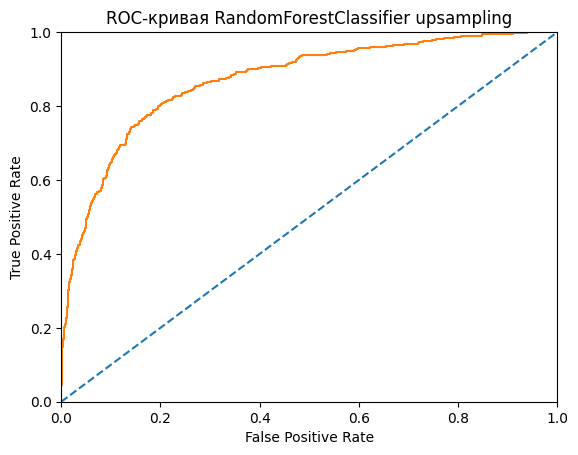

In [44]:
# using parametres from RandomForestClassifier upsampling

probabilities_final = model_final.predict_proba(features_test)
probabilities_one_final = probabilities_final[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_final)
plt.figure()

# <график>

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#plt.figure(figsize=(15, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate') # < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0]) # < применим функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая RandomForestClassifier upsampling') # < добавим к графику заголовок функцией plt.title() >
plt.show()

## Итоговый вывод:
В работе над проектом освоены полезные техники увеличения и уменьшения выборок, качественного кодирования и масштабирования, обучения моделей.
Важно отметить что качественное обучение моделей удается достичь блаодаря предотвращению утечки данных в процессе подготовки фичей и обучения моделей.
Наилучшей моделью оказалась модель Лес Решающих Деревьев с гиперпарамтрами глубина 9, n_estimators 100 на апсемплированной выборке.
Удалось достичь  F1 0.64, что говорит о хорошем соотношении точности и полноты предсказаний. Матрица ошибок помогает понять способность модели к качественному предсказанию истинно положительных ответов.

In [45]:
rfc_model = RandomForestClassifier(random_state=33)
rfc_params = {'n_estimators' : list(range(50, 250, 50)), 'max_depth' : range(1, 15, 1)}
scoring = {"f1_score" : 'f1', 'roc_auc_score' : 'roc_auc'}
rfc_random_cv = RandomizedSearchCV(rfc_model, rfc_params, cv=4, refit='f1_score', scoring=scoring)
rfc_random_cv.fit(features_test, target_test)
metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(rfc_random_cv.cv_results_)[metrics_columns].iloc[rfc_random_cv.best_index_]

In [46]:
final_metrics

mean_test_f1_score        0.5652341417853487
mean_test_roc_auc_score   0.8631453837816533
Name: 4, dtype: float64

In [47]:
rfc_random_cv.best_params_

{'n_estimators': 150, 'max_depth': 10}